In [199]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score, cross_val_predict
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV

In [200]:
filename='housing.csv'
df=pd.read_csv(filename)


In [201]:
print df.columns
for column in df.columns:
    print type(column)
    print df[column].isnull().value_counts()

Index([u'address', u'bed_bath', u'more_info', u'price', u'status',
       u'zip_code'],
      dtype='object')
<type 'str'>
False    7188
True      280
Name: address, dtype: int64
<type 'str'>
False    7188
True      280
Name: bed_bath, dtype: int64
<type 'str'>
False    7188
True      280
Name: more_info, dtype: int64
<type 'str'>
False    4926
True     2542
Name: price, dtype: int64
<type 'str'>
False    7188
True      280
Name: status, dtype: int64
<type 'str'>
False    7468
Name: zip_code, dtype: int64


address, bed_bath, more_info, and status each have 280 null cells.
price has 2542 null cells.
zip_code has 0 null cells.

In [202]:
print df.shape

(7468, 6)


2542 rows are missing a price.  Without a price we won't be able to categorize them as 'high' or 'low' price.  Therefore, I will be dropping them from the DataFrame.  Included in these 2542 row are 280 rows missing even more info.

In [203]:
df=df.dropna()

# for column in df_no_null_price.columns:
#     print type(column)
#     print df_no_null_price[column].isnull().value_counts()


In [204]:
df.shape

(4926, 6)

This is a function that will read in the address of each row, ignore the city and state, because they are all Chicago, IL, and then return the house number as an int (if available), and the street direction and street name (if available) as str.  For now, apt #s are being ingored.

In [205]:
def clean_address(value,counter):
    value=value.split(',')
    address=value[0]
    address=address.split(' ')
#     try:
#         address[0]=int(address[0])
#     except:
    address[0]=address[0].replace('-','')
    address[0]=address[0].replace('(Undisclosed','0')
    address[0]=address[0].replace('South','0')
    address[0]=address[0].replace('Rose','0')
    address[0]=address[0].replace('14th','0')
    address[0]=address[0].replace('The','0')
    address[0]=address[0].replace('Buckingham','0')
    address[0]=address[0].replace('W','0')
    address[0]=address[0].replace('Dobson','0')
    address[0]=address[0].replace('S','0')
    address[0]=address[0].replace('6441A','6641')
    address[0]=address[0].replace('N','0')
    address[0]=address[0].replace('0haw','0')
    address[0]=address[0].replace('Dickinson','0')
    address[0]=address[0].replace('Longfellow','0')
    address[0]=address[0].replace('Kipling','0')
    address[0]=address[0].replace('Paine','0')
    address[0]=address[0].replace('0ordsworth','0')
    address[0]=address[0].replace('Unit','0')
    address[0]=address[0].replace('5926.5','5926')
    address[0]=address[0].replace('Wood','0')
    address[0]=int(address[0])
#     st_direction=address[1]
#     street=None
    if(counter==2):
        if(len(address)>2):
            return address[2]
        else:
            return None
    return address[counter]

In [206]:
df['house_num']=df['address'].apply(lambda x: clean_address(x,0))
df['st_direction']=df['address'].apply(lambda x: clean_address(x,1))
df['street']=df['address'].apply(lambda x: clean_address(x,2))


In [207]:
df.head()


,address,bed_bath,more_info,price,status,zip_code,house_num,st_direction,street
0,"360 E Randolph St # 601-602, Chicago, IL","3 bds · 4 ba · 2,700 sqft",http://www.zillow.com/homedetails/360-E-Randol...,"$1,299,000",Condo For Sale,60601,360,E,Randolph
1,"8 E Randolph St UNIT 1006, Chicago, IL",1 bd · 1 ba · 850 sqft,http://www.zillow.com/homedetails/8-E-Randolph...,"$324,900",Condo For Sale,60601,8,E,Randolph
3,"340 E Randolph St APT 704, Chicago, IL","2 bds · 3 ba · 1,902 sqft",http://www.zillow.com/homedetails/340-E-Randol...,"$1,099,000",Condo For Sale,60601,340,E,Randolph
4,"420 E Waterside Dr UNIT 310, Chicago, IL","2 bds · 3 ba · 1,500 sqft",http://www.zillow.com/homedetails/420-E-Waters...,"$567,770",Condo For Sale,60601,420,E,Waterside
5,"155 N Harbor Dr # 1212-13, Chicago, IL","3 bds · 3 ba · 2,367 sqft",http://www.zillow.com/homedetails/155-N-Harbor...,"$1,350,000",Condo For Sale,60601,155,N,Harbor


This function will take the bed_bath column and return ints for number of beds, number of baths, and number of square feet.


In [208]:
def clean_bed_bath(value,counter):
    value=value.split('·')
    beds=value[0].split(' ')
    beds=beds[0]
    baths=None
    sqft=None
    if (len(value)>1):
        baths=value[1].split(' ')
        baths=baths[1]
    if (len(value)>2):
        sqft=value[2].split(' ')
        sqft=sqft[1]
        sqft=sqft.replace(',','')
        sqft=sqft.replace('--','None')
        sqft=sqft.replace('+','')
 
    if (len(beds)==0):
        beds='0'
    if not baths:
        baths='0'
#     if not sqft:
#         sqft=None
    beds=beds.replace("Studio",'0')
    beds=beds.replace('--','0')
    if ',' in beds:
        beds='0'
    beds=float(beds)
    baths=baths.replace('--','0')
    baths=float(baths)
    
    if sqft=='None':
        sqft=None
    if sqft:
        sqft=float(sqft)
    if counter==0:
        return beds
    if counter ==1:
        return baths
    if counter ==2:
        return sqft

In [209]:
df['beds']=df['bed_bath'].apply(lambda x: clean_bed_bath(x,0))
df['baths']=df['bed_bath'].apply(lambda x: clean_bed_bath(x,1))
df['sqft']=df['bed_bath'].apply(lambda x: clean_bed_bath(x,2))




In [210]:
print df.head()
print df[['sqft']].describe()

                                    address                   bed_bath  \
0  360 E Randolph St # 601-602, Chicago, IL  3 bds · 4 ba · 2,700 sqft   
1    8 E Randolph St UNIT 1006, Chicago, IL     1 bd · 1 ba · 850 sqft   
3    340 E Randolph St APT 704, Chicago, IL  2 bds · 3 ba · 1,902 sqft   
4  420 E Waterside Dr UNIT 310, Chicago, IL  2 bds · 3 ba · 1,500 sqft   
5    155 N Harbor Dr # 1212-13, Chicago, IL  3 bds · 3 ba · 2,367 sqft   

                                           more_info       price  \
0  http://www.zillow.com/homedetails/360-E-Randol...  $1,299,000   
1  http://www.zillow.com/homedetails/8-E-Randolph...    $324,900   
3  http://www.zillow.com/homedetails/340-E-Randol...  $1,099,000   
4  http://www.zillow.com/homedetails/420-E-Waters...    $567,770   
5  http://www.zillow.com/homedetails/155-N-Harbor...  $1,350,000   

           status  zip_code  house_num st_direction     street  beds  baths  \
0  Condo For Sale     60601        360            E   Randolph   3.

This function will turn the prices from stings into ints

In [211]:
def clean_price(value):
    value=value.replace('$','')
    value=value.replace(',','')
    value=value.replace('+','')
#     if (len(value)>10):
#         value=0
    if 'K' in value:
        value=value.replace('K','')
        value=float(value)
        value *= 1000
        
    elif 'M' in value:
        value=value.replace('M','')
        #value=float(value)
        value= float(value) 
        value *= 1000000
        value=float(value)
    else:
        value=float(value)
    return value

In [212]:
df['int_price']=df['price'].apply(clean_price)

# df['zip_code']=df['zip_code'].apply(lambda x: x.mean() if (x==None) else x)
# df['house_num']=df['house_num'].apply(lambda x: x.mean() if (x==None) else x)
# df['beds']=df['beds'].apply(lambda x: x.mean() if (x==None) else x)
# df['baths']=df['baths'].apply(lambda x: x.mean() if (x==None) else x)

##I am up to here Friday at 10 am
df.loc[df['sqft'].isnull(),'sqft']=df['sqft'].mean()
df.loc[df['zip_code'].isnull(),'zip_code']=df['zip_code'].mean()
df.loc[df['house_num'].isnull(),'house_num']=df['house_num'].mean()
df.loc[df['beds'].isnull(),'beds']=df['beds'].mean()
df.loc[df['baths'].isnull(),'baths']=df['baths'].mean()
df.loc[df['int_price'].isnull(),'int_price']=df['int_price'].mean()



# df.loc['sqft'][df.sqft.isnull()]=df['sqft'].apply(lambda x: df['sqft'].mean() if (x==np.nan) else x)


# df['int_price']=df['int_price'].apply(lambda x: x.median() if (x==None) else x)

In [213]:
# df[df.sqft.isnull()]['sqft'] = df['sqft'].mean()

df.loc[df['sqft'].isnull(),'sqft']=df['sqft'].mean()
print df['sqft'].mean()
print df['sqft']

1804.49085038
0       2700.00000
1        850.00000
3       1902.00000
4       1500.00000
5       2367.00000
6       1250.00000
7       1200.00000
8       1547.00000
9       1209.00000
10       835.00000
11      1136.00000
12      1067.00000
13      1250.00000
14      3500.00000
15      1348.00000
16       700.00000
17      1070.00000
18       685.00000
19       685.00000
20       571.00000
21      1143.00000
22      1950.00000
23       685.00000
24      1950.00000
25       826.00000
26       826.00000
27      1348.00000
28      2002.00000
29      1950.00000
31      1950.00000
           ...    
7341     970.00000
7342    1804.49085
7343    1022.00000
7349    1360.00000
7350    1804.49085
7351     893.00000
7352    1152.00000
7354     825.00000
7355     731.00000
7356     891.00000
7357     848.00000
7359    1487.00000
7362    2463.00000
7363     700.00000
7365     904.00000
7367    1243.00000
7369    1000.00000
7376     800.00000
7380     900.00000
7385    1044.00000
7388    1256.0000

In [214]:
print df.head()
print type(df['int_price'][0])

                                    address                   bed_bath  \
0  360 E Randolph St # 601-602, Chicago, IL  3 bds · 4 ba · 2,700 sqft   
1    8 E Randolph St UNIT 1006, Chicago, IL     1 bd · 1 ba · 850 sqft   
3    340 E Randolph St APT 704, Chicago, IL  2 bds · 3 ba · 1,902 sqft   
4  420 E Waterside Dr UNIT 310, Chicago, IL  2 bds · 3 ba · 1,500 sqft   
5    155 N Harbor Dr # 1212-13, Chicago, IL  3 bds · 3 ba · 2,367 sqft   

                                           more_info       price  \
0  http://www.zillow.com/homedetails/360-E-Randol...  $1,299,000   
1  http://www.zillow.com/homedetails/8-E-Randolph...    $324,900   
3  http://www.zillow.com/homedetails/340-E-Randol...  $1,099,000   
4  http://www.zillow.com/homedetails/420-E-Waters...    $567,770   
5  http://www.zillow.com/homedetails/155-N-Harbor...  $1,350,000   

           status  zip_code  house_num st_direction     street  beds  baths  \
0  Condo For Sale   60601.0      360.0            E   Randolph   3.

Next I will use get_dummies to create dummy variables for each possible 'status' for the row.

In [215]:
dummies=pd.get_dummies(df['status'])
df=df.join(dummies,rsuffix='_from_dummies')
print df.head()

                                    address                   bed_bath  \
0  360 E Randolph St # 601-602, Chicago, IL  3 bds · 4 ba · 2,700 sqft   
1    8 E Randolph St UNIT 1006, Chicago, IL     1 bd · 1 ba · 850 sqft   
3    340 E Randolph St APT 704, Chicago, IL  2 bds · 3 ba · 1,902 sqft   
4  420 E Waterside Dr UNIT 310, Chicago, IL  2 bds · 3 ba · 1,500 sqft   
5    155 N Harbor Dr # 1212-13, Chicago, IL  3 bds · 3 ba · 2,367 sqft   

                                           more_info       price  \
0  http://www.zillow.com/homedetails/360-E-Randol...  $1,299,000   
1  http://www.zillow.com/homedetails/8-E-Randolph...    $324,900   
3  http://www.zillow.com/homedetails/340-E-Randol...  $1,099,000   
4  http://www.zillow.com/homedetails/420-E-Waters...    $567,770   
5  http://www.zillow.com/homedetails/155-N-Harbor...  $1,350,000   

           status  zip_code  house_num st_direction     street  beds  \
0  Condo For Sale   60601.0      360.0            E   Randolph   3.0   
1 

One last column I want to add is price per square foot (price / sqft)

In [216]:
# def pp_sqft(price,sqft):
#     pp_sqft=price / sqft
#     return pp_sqft
    


# df['pp_sqft']=df['int_price'].apply(lambda x: pp_sqft(x,df['sqft']))
df['pp_sqft']=df['int_price'].divide(df['sqft'])


In [217]:
print df[['int_price','sqft','pp_sqft']].head()

   int_price    sqft     pp_sqft
0  1299000.0  2700.0  481.111111
1   324900.0   850.0  382.235294
3  1099000.0  1902.0  577.812829
4   567770.0  1500.0  378.513333
5  1350000.0  2367.0  570.342205


Having a target, df[['pp_sqft']], I will attempt to create a way to categorize each as High_price or Low_price based on the price per square foot.  I will draw a plot to take a look at the data.

In [218]:
print df[['pp_sqft']].describe()

            pp_sqft
count  4.926000e+03
mean   2.420684e+03
std    3.393069e+04
min    5.541729e-01
25%    9.445833e+01
50%    1.940633e+02
75%    3.158245e+02
max    1.149000e+06


In [219]:
# target=df[['pp_sqft']].values
# fig=plt.figure()
# ax=fig.add_subplot(111)
# plt.hist(target)
# plt.savefig("Price_per_sqft.png")

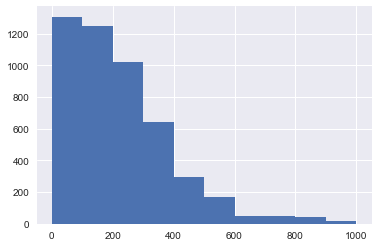

In [220]:
target=df[['pp_sqft']].values

#print df['pp_sqft'].isnull().sum()
fig=plt.figure()
ax=fig.add_subplot(111)
ax.hist(target, range=(0,1000))
#ax.set_xlim(0,500)
#ax.set_ylim(0,100)
#plt.hist(target[0:300], bins=100, edgecolor='b')#, width=10)

#plt.hist(target)
plt.savefig('Price_per_sqft.png')
#print target[0:30]


#print target[0:300].min()
#print target[0:300].mean()


In [221]:
df[['pp_sqft']].describe()
#df_target[0].sort_values(ascending=False)


,pp_sqft
count,4.926000e+03
mean,2.420684e+03
std,3.393069e+04
min,5.541729e-01
25%,9.445833e+01
50%,1.940633e+02
75%,3.158245e+02
max,1.149000e+06


I will consider anything above the median of $194/sqft as a High cost house, and anything below the median as a Low cost house.  The mean is skewed to the right due to outliers, so median seems to be at a more reasonable cutoff point.  I will add a new column to my data "is_high" which will be 1 for High cost and 0 for Low cost.

In [260]:
def above_median(value):
    if value>=194:
        return 1
    else:
        return 0
df['is_high']=df['pp_sqft'].apply(above_median)

print df[['pp_sqft','is_high']].tail()

# df['is_high']=df[['pp_sqft']].apply(lambda x: 1 if (x>=220) else 0)
# df[['is_high']]=df.loc[(df['pp_sqft']>=20),True]

        pp_sqft  is_high
7441  32.965934        0
7446  24.937782        0
7447  78.085642        0
7459  33.022862        0
7460   2.770865        0


Now I have a target to predict, df[['is_high']], I will now try to find a model using various predictors to best fit my model, I will first make a model with kNearestNeighbors, and then try a model with LogisticRegression.

In [261]:
print df.columns
print df.head()

Index([u'address', u'bed_bath', u'more_info', u'price', u'status', u'zip_code',
       u'house_num', u'st_direction', u'street', u'beds', u'baths', u'sqft',
       u'int_price', u'Apartment For Sale', u'Auction', u'Co-op For Sale',
       u'Coming Soon', u'Condo For Sale', u'For Sale by Owner', u'Foreclosure',
       u'House For Sale', u'Lot/Land For Sale', u'Make Me Move®',
       u'New Construction', u'Townhouse For Sale', u'pp_sqft', u'is_high'],
      dtype='object')
                                    address                   bed_bath  \
0  360 E Randolph St # 601-602, Chicago, IL  3 bds · 4 ba · 2,700 sqft   
1    8 E Randolph St UNIT 1006, Chicago, IL     1 bd · 1 ba · 850 sqft   
3    340 E Randolph St APT 704, Chicago, IL  2 bds · 3 ba · 1,902 sqft   
4  420 E Waterside Dr UNIT 310, Chicago, IL  2 bds · 3 ba · 1,500 sqft   
5    155 N Harbor Dr # 1212-13, Chicago, IL  3 bds · 3 ba · 2,367 sqft   

                                           more_info       price  \
0  http://w

In [297]:
x=StandardScaler().fit_transform(df[[ u'zip_code',
        u'beds', u'baths', u'sqft',

       u'Apartment For Sale', u'Auction', u'Co-op For Sale',
       u'Coming Soon', u'Condo For Sale', u'For Sale by Owner', u'Foreclosure',
       u'House For Sale', u'Lot/Land For Sale',
       u'New Construction', u'Townhouse For Sale' ]])

#taken out u'house_num', 

y=df[u'is_high'].values.reshape(-1,1)
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.4)






In [298]:
knn=KNeighborsClassifier(n_neighbors=1)

In [299]:
knn.fit(x_train,y_train)
print knn.score(x_train,y_train)

0.990186125212


/Users/ariburian/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':


In [300]:
print knn.predict(x_train)
print knn.predict_proba(x_train)

[1 0 0 ..., 1 1 0]
[[ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 ..., 
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]]


In [301]:
print knn.score(x_test,y_test)

0.80162354135


Now let's try a Logistic Regression

First, I will made a seaborn heatmap and do a grid_search to look at the correlations between variables.

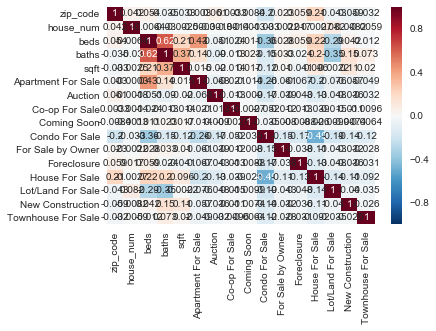

In [267]:
number_columns=df[[u'zip_code',u'house_num',
        u'beds', u'baths', u'sqft',
       u'Apartment For Sale', u'Auction', u'Co-op For Sale',
       u'Coming Soon', u'Condo For Sale', u'For Sale by Owner', u'Foreclosure',
       u'House For Sale', u'Lot/Land For Sale',
       u'New Construction', u'Townhouse For Sale' ]]


sns.heatmap(number_columns.corr(),annot=True)


In [268]:
lr=LogisticRegression()

hyperparameters={'penalty':['l1','l2'], 
                'C': [0.01,1.0,10.0,100.0,1000.0]}

grid_search=GridSearchCV(lr,hyperparameters,verbose=10)

# lr.fit(number_columns,y)


In [269]:
x=df[[u'zip_code',u'house_num',
        u'beds', u'baths', u'sqft',
       u'Apartment For Sale', u'Auction', u'Co-op For Sale',
       u'Coming Soon', u'Condo For Sale', u'For Sale by Owner', u'Foreclosure',
       u'House For Sale', u'Lot/Land For Sale',
       u'New Construction', u'Townhouse For Sale' ]]


y=df[u'is_high']
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.4)

In [270]:
#grid_search.fit(x_train,y_train)
print x_train[0:5]
print y_train[0:5]
grid_search.fit(x_train,y_train)

      zip_code  house_num  beds  baths        sqft  Apartment For Sale  \
3711   60630.0     4258.0   2.0    1.0  1000.00000                   0   
774    60607.0      111.0   3.0    4.0  2624.00000                   0   
203    60602.0      130.0   2.0    2.0  1336.00000                   0   
4162   60633.0    12944.0   3.0    1.0  1804.49085                   0   
5363   60643.0    11436.0   0.0    1.5  1040.00000                   0   

      Auction  Co-op For Sale  Coming Soon  Condo For Sale  For Sale by Owner  \
3711        0               0            0               1                  0   
774         0               0            0               1                  0   
203         0               0            0               1                  0   
4162        0               0            0               0                  0   
5363        1               0            0               0                  0   

      Foreclosure  House For Sale  Lot/Land For Sale  New Constructi

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.2s remaining:    0.0s


[CV] ...................... penalty=l2, C=1.0, score=0.721827 -   0.0s
[CV] penalty=l2, C=1.0 ...............................................
[CV] ...................... penalty=l2, C=1.0, score=0.710660 -   0.0s
[CV] penalty=l2, C=1.0 ...............................................
[CV] ...................... penalty=l2, C=1.0, score=0.748223 -   0.0s
[CV] penalty=l1, C=10.0 ..............................................
[CV] ..................... penalty=l1, C=10.0, score=0.739086 -   0.1s
[CV] penalty=l1, C=10.0 ..............................................
[CV] ..................... penalty=l1, C=10.0, score=0.724873 -   0.1s
[CV] penalty=l1, C=10.0 ..............................................
[CV] ..................... penalty=l1, C=10.0, score=0.756345 -   0.2s
[CV] penalty=l2, C=10.0 ..............................................
[CV] ..................... penalty=l2, C=10.0, score=0.720812 -   0.0s
[CV] penalty=l2, C=10.0 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    2.8s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.01, 1.0, 10.0, 100.0, 1000.0]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=10)

In [271]:
grid_search.best_estimator_.fit(x_train,y_train)

LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [272]:
grid_search.best_estimator_.score(x_train,y_train)

0.73807106598984773

In [310]:
lasso_lr=LogisticRegression(penalty='l1',C=100.0)

In [311]:
lasso_lr.fit(x_train,y_train)

LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [312]:
lasso_lr.score(x_train,y_train)

0.7363790186125212

In [313]:
lasso_lr.score(x_test,y_test)

0.72957889396245557